In [1]:
# Clear memory
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import ipywidgets
ipywidgets.Widget.close_all()

import SimpleITK
import datetime
import gc # Garbage collected
import numpy as np
import sys, os
import time
import tifffile
import matplotlib.pyplot as plt
import scipy
from tkinter import Tk
from tkinter.filedialog import askopenfilename, askopenfilenames, askdirectory
import torch
import skimage
from skimage import measure
from skimage.morphology import skeletonize
import pickle
import networkx as nx
import sknw # https://github.com/Image-Py/sknw

import multiprocessing

this_path = os.getcwd()
print(this_path)


import h5py
# import File
from scripts import *
import wrapper_ASTRA

/global/u2/e/eboigne/als_biomass_analysis/tomoTools


In [3]:
 path_save = '/global/homes/e/eboigne/cfs_als/2022_wood/'

case = 'run21_oak_lowHeat'
# case = 'run23_walnut_lowHeat'
# case = 'run24_birch_lowHeat'
# case = 'run26_birch_highHeat'

voxel_size = 3.24*2 # [microns]

list_cases_folder_name = sorted([e for e in os.listdir(path_save+case) if not 'probe' in e and not '.tif' in e and not '.pickle' in e])
run = case[3:5]+'_Sample'
list_cases_h5 = sorted([e for e in os.listdir(path_save) if '.h5' in e and run in e])

print(list_cases_folder_name)

['01', '02', '03', '04', '05a', '05b', '06a', '06b', '07a', '07b', '08a', '08b', '09a', '09b', '10a', '10b', '11a', '11b', '12a', '12b', '13a', '13b', '14a', '14b', '15a', '15b', '16a', '16b', '17a', '17b', '18a', '18b', '19a', '19b', '20a', '20b', '21a', '21b', '22', '23', '24']


In [ ]:
ind_slice = 250

slices = []
for ind_case, this_case in enumerate(list_cases_folder_name[:]):
    slices.append(File(path_save+case+'/'+this_case+'/b_movingRegisteredToStatic/').read(ind_slice))
    print(ind_case, this_case)

slices = np.array(slices)
print(slices.shape)
File(path_save+case+'/probe_slice_'+str(ind_slice).zfill(4)).saveTiffStack(slices)

In [4]:
c = []
for this_case in enumerate(list_cases_h5):
    c.append(this_case[1][35:37])

t = []

list_scans = []

for this_case in enumerate(c):
    if str(this_case[1]) in list_cases_folder_name or '-post' in [e for e in list_cases_folder_name if this_case[1] in e][0]:
        cc = list_cases_h5[this_case[0]][9:15]
        h = cc[0:2]
        m = cc[2:4]
        s = cc[4:]
        ts = float(int(h)*3600+int(m)*60+int(s))
        t.append(ts) #c
        print(len(t), this_case, 'c', ts)
    else:
        cc = list_cases_h5[this_case[0]][9:15]
        h = cc[0:2]
        m = cc[2:4]
        s = cc[4:]
        ts0 = float(int(h)*3600+int(m)*60+int(s))
        t.append(ts0) #a
        ts1 = 26.26 + ts0
        t.append(ts1) #b
        print(len(t), this_case, 'a/b', ts0 ,ts1)

scan_times = np.array(t) - t[0]


for ind_scan,scan_time in enumerate(scan_times):
    this_scan = Data()
    # print(ind_scan)
    this_scan.scan_time = scan_time
    this_scan.folder_name = list_cases_folder_name[ind_scan]
    this_scan.full_path = path_save+case+'/'+this_scan.folder_name
    this_scan.ind = ind_scan
    list_scans.append(this_scan)

assert(len(list_cases_folder_name) ==len(scan_times)), 'Wrong sizes'

1 (0, '01') c 36265.0
2 (1, '02') c 36575.0
3 (2, '03') c 36886.0
4 (3, '04') c 37585.0
6 (4, '05') a/b 37767.0 37793.26
8 (5, '06') a/b 37949.0 37975.26
10 (6, '07') a/b 38132.0 38158.26
12 (7, '08') a/b 38312.0 38338.26
14 (8, '09') a/b 38503.0 38529.26
16 (9, '10') a/b 38694.0 38720.26
18 (10, '11') a/b 38882.0 38908.26
20 (11, '12') a/b 39072.0 39098.26
22 (12, '13') a/b 39260.0 39286.26
24 (13, '14') a/b 39443.0 39469.26
26 (14, '15') a/b 39621.0 39647.26
28 (15, '16') a/b 39805.0 39831.26
30 (16, '17') a/b 39985.0 40011.26
32 (17, '18') a/b 40166.0 40192.26
34 (18, '19') a/b 40346.0 40372.26
36 (19, '20') a/b 40544.0 40570.26
38 (20, '21') a/b 40725.0 40751.26
39 (21, '22') c 40914.0
40 (22, '23') c 41225.0
41 (23, '24') c 41534.0


In [5]:
print(list_cases_folder_name)

['01', '02', '03', '04', '05a', '05b', '06a', '06b', '07a', '07b', '08a', '08b', '09a', '09b', '10a', '10b', '11a', '11b', '12a', '12b', '13a', '13b', '14a', '14b', '15a', '15b', '16a', '16b', '17a', '17b', '18a', '18b', '19a', '19b', '20a', '20b', '21a', '21b', '22', '23', '24']


In [6]:
def compute_height(properties):
    for prop in properties:
        bbox = prop.bbox
        prop.height = bbox[3]-bbox[0] # Along z, in pixels
    return(properties)

def compute_equivalent_cylinder_diameters(properties):
    for prop in properties:
        equivalent_cylinder_cross_section = prop.area / prop.height
        prop.equivalent_cylinder_diameter = np.sqrt(4*equivalent_cylinder_cross_section/np.pi) * voxel_size
    return(properties)

def get_path_length(graph, path):
    this_sum=0
    for i in range(len(path)-1):
        this_sum += graph.get_edge_data(path[i], path[i+1])['weight']
    return(this_sum)

def longest_simple_path(graph, source, target):
    longest_path = None
    longest_path_length = 0
    for path in nx.all_simple_paths(graph, source=source, target=target):
        path_length = get_path_length(graph,path)
        if path_length > longest_path_length:
            longest_path_length = path_length
            longest_path = path
    return longest_path, longest_path_length

def find_longest_subgraph_from_ends(graph, height):

    ind_end_nodes = [x for x in graph.nodes if graph.degree(x) == 1]
    ind_end_bottom = [x for x in ind_end_nodes if graph.nodes[x]['o'][0] <= height/2.0]
    ind_end_top = [x for x in ind_end_nodes if not x in ind_end_bottom]

    longest_path_subgraph = None
    longest_path_length = 0
    longest_path = []
    for ind_bot in ind_end_bottom:
        for ind_top in ind_end_top:
            this_longest_path, this_longest_path_length = longest_simple_path(graph, source=ind_bot, target=ind_top)
            this_longest_path_subgraph = graph.subgraph(this_longest_path)

            if this_longest_path_length > longest_path_length:
                longest_path_length = this_longest_path_length
                longest_path = this_longest_path
                longest_path_subgraph = this_longest_path_subgraph

    return(longest_path_subgraph, longest_path, longest_path_length)

def compute_tortuosity(skeleton_properties):

    for ind_pore in range(len(skeleton_properties)):

        graph = sknw.build_sknw(skeleton_properties[ind_pore].image, multi=False, iso=False, ring=False, full=True)
        longest_path_subgraph, longest_path, longest_path_length = find_longest_subgraph_from_ends(graph, skeleton_properties[ind_pore].height)

        if longest_path_length == 0:
            longest_path_length = np.nan

        skeleton_properties[ind_pore].length_skeleton = longest_path_length
        skeleton_properties[ind_pore].longest_path = longest_path
        # skeleton_properties[ind_pore].longest_path_subgraph = longest_path_subgraph
        skeleton_properties[ind_pore].tortuosity = longest_path_length / skeleton_properties[ind_pore].height

        # print(ind_pore, longest_path_length, skeleton_properties[ind_pore].tortuosity)

        # print(len(np.array([graph.degree(x) > 2 for x in graph.nodes])), skeleton_properties[ind_pore].tortuosity)
        # File(path_save+'/runAll_figures/test/'+str(ind_pore).zfill(4)).saveTiffStack(~(skeleton_properties[ind_pore].image.astype('bool')), type='bool')

    return(skeleton_properties)

def compute_skeleton(this_scan, mask_pores, force_redo = False):

    if force_redo or not 'b_movingRegisteredToStatic_maskPores_skeleton' in os.listdir(this_scan.full_path):
        skeleton = skeletonize(mask_pores)
        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskPores_skeleton').saveTiffStack(skeleton, type = 'bool')
    else:
        print('\tRe-loading skeleton')
        skeleton = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskPores_skeleton').readAll()
    return(skeleton)

def find_top_bottom_slices_ind(this_scan, mask_solid, ind_all_top, ind_all_bottom):

    this_scan.ind_all_margin = 100
    this_scan.ind_margin = 30
    this_scan.relative_porosity_threshold = 0.15

    mask_solid_slice_sum = np.sum(np.sum(mask_solid, axis = 2), axis = 1)
    mean_area_ind_all = np.mean(mask_solid_slice_sum[ind_all_top+this_scan.ind_all_margin:ind_all_bottom-this_scan.ind_all_margin])

    this_scan.relative_porosity = np.abs(mean_area_ind_all-mask_solid_slice_sum)/mean_area_ind_all

    this_scan.ind_top = np.min(np.where(this_scan.relative_porosity<this_scan.relative_porosity_threshold)) + this_scan.ind_margin
    this_scan.ind_bottom = np.max(np.where(this_scan.relative_porosity<this_scan.relative_porosity_threshold)) - this_scan.ind_margin

    this_scan.height_ROI = this_scan.ind_bottom-this_scan.ind_top + 1

    print('\t\tDetected ROI:\tind_top: '+str(this_scan.ind_top)+', ind_bottom: '+str(this_scan.ind_bottom)+', height: '+str(this_scan.height_ROI))
    if (this_scan.height_ROI < 200):
        print('\t\t\t\t/!\ WARNING: small height of ROI detected: check the cropping of mask solid')

    return(this_scan)

def mask_crop_ROI(mask, ind_top, ind_bottom):
    mask[:ind_top] = False
    mask[ind_bottom:] = False
    return(mask)

def close_mask_solid(this_scan, mask_solid, mask_needle, force_redo = False):

    if force_redo or not 'b_movingRegisteredToStatic_maskSolidClosed' in os.listdir(this_scan.full_path):

        # Option #1: Morphological closing to close the pores
        # chunk_size = (500, 500, 500)
        # filter_half_width = 12
        # structure = custom_3d_kernel_sphere(filter_half_width)
        # mask_solid_dilated = apply_3d_image_processing_on_subvolumes(mask_solid, fast_pytorch_mask_dilation, chunk_size_max = chunk_size, overlap = filter_half_width, radius = filter_half_width)
        # mask_solid_closed = ~apply_3d_image_processing_on_subvolumes(~mask_solid_dilated, fast_pytorch_mask_dilation, chunk_size_max = chunk_size, overlap = filter_half_width, radius = filter_half_width)

        # Option #2: Fill holes algorithm run slice by slice
        n_threads = 16
        mask_solid_closed = np.zeros_like(mask_solid)
        with multiprocessing.Pool(n_threads) as p:
            mask_solid_closed = np.array(p.map(scipy.ndimage.morphology.binary_fill_holes, mask_solid))

        # 1 core version of option #2
        # for ind, slice in enumerate(mask_solid):
        #     mask_solid_closed[ind] = scipy.ndimage.morphology.binary_fill_holes(slice)
        #     print(ind)

        mask_solid_closed[mask_needle] = False
        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolidClosed').saveTiffStack(mask_solid_closed, type = 'bool')
    else:
        print('\tRe-loading mask solid closed')
        mask_solid_closed = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolidClosed').readAll()

    return(mask_solid_closed.astype('bool'))

def rotate_data(data, rot_coronal_Fiji, rot_sagittal_Fiji, rot_z_Fiji = 0.0):
    pad = 1
    transform_rotation = sitk.Euler3DTransform()
    center_xyz = (data.shape[0] / 2.0+pad, data.shape[1] / 2.0+pad, data.shape[2] / 2.0+pad) # TODO: Is this correct? Not consistent with below
    center_angle = 0.0
    offsets_xyz = (0.0, 0.0, 0.0)

    transform_rotation.SetFixedParameters((center_xyz[0], center_xyz[1], center_xyz[2], center_angle))
    eulerAngle_xyz_deg = (-rot_sagittal_Fiji, rot_coronal_Fiji, 0.0)
    transform_rotation.SetParameters((eulerAngle_xyz_deg[0]/180.0*np.pi, eulerAngle_xyz_deg[1]/180.0*np.pi, eulerAngle_xyz_deg[2]/180.0*np.pi, offsets_xyz[0], offsets_xyz[1], offsets_xyz[2]))

    data_bigger = np.zeros([data.shape[0]+pad*2, data.shape[1]+pad*2, data.shape[2]+pad*2])
    data_bigger[pad:-pad, pad:-pad, pad:-pad] = data
    data_out = applyTransformToVolume(data_bigger, data_bigger, transform_rotation)

    # Then only axial rotation. Can't do all axis at once to match Fiji
    if rot_z_Fiji != 0:
        center_xyz = (data_out.shape[2] / 2.0, data_out.shape[1] / 2.0, data_out.shape[0] / 2.0)
        transform_rotation.SetFixedParameters((center_xyz[0], center_xyz[1], center_xyz[2], center_angle))
        eulerAngle_xyz_deg = (0.0, 0.0, -rot_z_Fiji)
        offsets_xyz2 = (0.0, -50.0, 0.0)
        transform_rotation.SetParameters((eulerAngle_xyz_deg[0]/180.0*np.pi, eulerAngle_xyz_deg[1]/180.0*np.pi, eulerAngle_xyz_deg[2]/180.0*np.pi, offsets_xyz2[0], offsets_xyz2[1], offsets_xyz2[2]))
        data_out2 = applyTransformToVolume(data_out, data_out, transform_rotation)
    else:
        data_out2 = data_out

    return(data_out2[pad:-pad, pad:-pad, pad:-pad])

def analyze_pores_2d(this_scan, mask_pores):
    tic = time.time()

    this_scan.slice_angles_to_growth = []
    this_scan.slice_ellipse_major_diameters = []
    this_scan.slice_ellipse_minor_diameters = []
    this_scan.slice_ellipse_eccentricity = []
    this_scan.slice_areas = []
    this_scan.slice_eq_diameters = []
    this_scan.slice_perimeters = []

    for ind, slice in enumerate(mask_pores):
        slice_lab = measure.label(slice)
        slice_properties = np.array(measure.regionprops(slice_lab))

         # Angle w.r.t vertical (growth axis), with positive being CCW, in degrees, from -90 to 90
        angles = 180 / np.pi * np.array([p.orientation for p in slice_properties]) # From -90 to 90
        # angles[angles<0] = 180+angles[angles<0]
        this_scan.slice_angles_to_growth.append(angles)

        this_scan.slice_ellipse_major_diameters.append(np.array([p.axis_major_length for p in slice_properties]))
        this_scan.slice_ellipse_minor_diameters.append(np.array([p.axis_minor_length for p in slice_properties]))
        this_scan.slice_ellipse_eccentricity.append(np.array([p.eccentricity for p in slice_properties]))
        this_scan.slice_eq_diameters.append(np.array([p.equivalent_diameter_area for p in slice_properties]))
        this_scan.slice_perimeters.append(np.array([p.perimeter for p in slice_properties]))
        this_scan.slice_areas.append(np.array([p.area for p in slice_properties]))

        if ind % 100 == 0:
            print('.', end='')

    return(this_scan)

def mean_attenuation_volume(this_scan, mask_to_use, data):
    mu_s = np.nanmean(data[mask_to_use])
    V_s = np.nansum(mask_to_use.flatten())
    V_s_m = np.nansum(mask_to_use.flatten())*(voxel_size*10**-6)**3 #[m3]
    return(mu_s,V_s, V_s_m)

def cleanup_keep_single_particle(mask_solid):

    # Morphological opening to separate sample from artifact regions
    chunk_size = (500, 500, 500)
    filter_half_width = 7
    structure = custom_3d_kernel_sphere(filter_half_width)
    mask_solid_eroded = ~apply_3d_image_processing_on_subvolumes(~mask_solid, fast_pytorch_mask_dilation, chunk_size_max = chunk_size, overlap = filter_half_width, radius = filter_half_width)
    mask_solid_opened = apply_3d_image_processing_on_subvolumes(mask_solid_eroded, fast_pytorch_mask_dilation, chunk_size_max = chunk_size, overlap = filter_half_width, radius = filter_half_width)

    # Isolate largest connected particle
    lab = measure.label(mask_solid_opened)
    properties = np.array(measure.regionprops(lab))
    areas = np.array([e.area for e in properties])
    ind_max_area = np.argmax(areas)
    mask_out = lab == properties[ind_max_area].label

    return(mask_out)

def compute_mask_solid(this_scan, data, threshold, force_redo = False):

    if force_redo or not 'b_movingRegisteredToStatic_maskSolid' in os.listdir(this_scan.full_path):

        threshold_needle = 4.0 # Linear attenuation threshold [/cm]
        mask_growth_needle = 10 # Grow the mask obtained using threshold_needle with this amount of pixels
        mask_enclosing_circle = tifffile.imread(path_save+case+'/maskEnclosingCircle.tif') > 0
        bin_factor_dilatation = 1 # Binning before smoothing, as an option to speed things up for large kernels
        filter_half_width = 3 # After binning (equal to sigma for gaussian filter)

        kernel = custom_3d_gaussian_filter(filter_half_width)

        if bin_factor_dilatation > 1:
            data_smoothed = fast_pytorch_bin_3d(data,bin_factor_dilatation, chunk_size = 71)
        else:
            data_smoothed = data

        print('\t3D smoothing for thresholding of mask_solid and mask_needle:')
        data_smoothed = apply_3d_image_processing_on_subvolumes(data_smoothed, fast_pytorch_convolution, kernel_array = kernel, chunk_size_max = (500, 500, 500), overlap = 3*filter_half_width)

        if bin_factor_dilatation > 1:
            data_smoothed = skimage.transform.rescale(data_smoothed, bin_factor_dilatation, multichannel=False)

        File(this_scan.full_path+'/b_movingRegisteredToStatic_smoothed').saveTiffStack(data_smoothed)

        mask_needle = data_smoothed > threshold_needle
        mask_needle = apply_3d_image_processing_on_subvolumes(mask_needle, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = mask_growth_needle, radius = mask_growth_needle)

        mask_solid = data_smoothed > threshold
        mask_solid[mask_needle] = False

        for ind, slice in enumerate(mask_solid):
            slice[~mask_enclosing_circle] = False
            mask_solid[ind] = slice

        # Computing top and bottom indices for a ROI within the solid
        this_scan = find_top_bottom_slices_ind(this_scan, mask_solid, this_scan.ind_all_top, this_scan.ind_all_bottom)

        # Close mask_solid, using 2D fill holes algorithm slice by slice
        print('\tClosing mask solid')
        mask_solid_closed = close_mask_solid(this_scan, mask_solid, mask_needle, force_redo = force_redo)

        # Clean up mask_solid_closed and mask_solid to keep single large particle region, and remove artifacts above and below sample
        print('\tCleaning up mask solid (3D opening), isolating largest particle')
        mask_solid_closed = cleanup_keep_single_particle(mask_solid_closed)
        mask_solid_closed = mask_crop_ROI(mask_solid_closed, this_scan.ind_top-this_scan.ind_margin-20, this_scan.ind_bottom+this_scan.ind_margin+20)
        mask_solid = mask_solid * mask_solid_closed

        print('\tSaving mask_solid and mask_solid_closed:')
        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolid').saveTiffStack(mask_solid, type = 'bool')
        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolidClosed').saveTiffStack(mask_solid_closed, type = 'bool')
        # File(this_scan.full_path+'/b_movingRegisteredToStatic_maskNeedle').saveTiffStack(mask_needle, type = 'bool')

    else:
        print('\tRe-loading mask_solid and mask_solid_closed')
        mask_solid = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolid').readAll()
        mask_solid_closed = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolidClosed').readAll()
        # mask_needle = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskNeedle').readAll()

    return(this_scan, mask_solid.astype('bool'), mask_solid_closed.astype('bool'))


0.0727946661165659


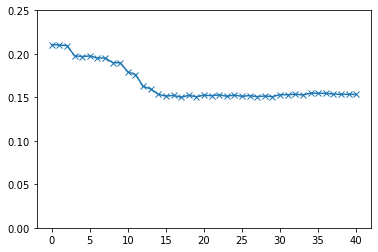

In [7]:
# Rotation
rot_coronal_Fiji = 1.0 # [Deg]
rot_sagittal_Fiji = -1.0 # [Deg]
rot_z_Fiji = 43.0 # [Deg] This angle: such that tree growth is vertical from bottom to top in Fiji, after sagittal / coronal rotation

# Top and bottom indices along z that contain sample for all scans (after rotation /!\)
ind_all_top = 125
ind_all_bottom = 510

threshold = 0.10 # Linear attenuation threshold [/cm], gas to wood

mean_mu_values = np.load(path_save+'/threshold_attenuation_values/run21.npy')
plt.plot(mean_mu_values,'x-')
plt.ylim(0,0.25)
print(threshold * mean_mu_values[-1]/mean_mu_values[0])

In [7]:
# Rotation
rot_coronal_Fiji = -1.4 # [Deg]
rot_sagittal_Fiji = -5.0 # [Deg]
rot_z_Fiji = -169.0 # [Deg] This angle: such that tree growth is vertical from bottom to top in Fiji, after sagittal / coronal rotation

# Top and bottom indices along z that contain sample for all scans (after rotation /!\)
ind_all_top = 140
ind_all_bottom = 470

threshold = 0.065 # Linear attenuation threshold [/cm], gas to wood

In [7]:
# Rotation
rot_coronal_Fiji = -1.0 # [Deg]
rot_sagittal_Fiji = -5.0 # [Deg]
rot_z_Fiji = -91.5 # [Deg] This angle: such that tree growth is vertical from bottom to top in Fiji, after sagittal / coronal rotation

# Top and bottom indices along z that contain sample for all scans (after rotation /!\)
ind_all_top = 130
ind_all_bottom = 465

threshold = 0.05 # Linear attenuation threshold [/cm], gas to wood

In [150]:
# Rotation
rot_coronal_Fiji = -0.2 # [Deg]
rot_sagittal_Fiji = 0.5 # [Deg]
rot_z_Fiji = 40.0 # [Deg] This angle: such that tree growth is vertical from bottom to top in Fiji, after sagittal / coronal rotation

# Top and bottom indices along z that contain sample for all scans (after rotation /!\)
ind_all_top = 170
ind_all_bottom = 480

threshold = 0.05 # Linear attenuation threshold [/cm], gas to wood


In [8]:
ind_scan = 34
this_scan = list_scans[ind_scan]
print('Running scan #'+str(ind_scan+1)+' - '+this_scan.folder_name)

# Re-load scan data
with open(path_save+case+'/post_pro_data.pickle', 'rb') as handle:
    list_scans = pickle.load(handle)

torch.cuda.set_device(0)
print(torch.cuda.current_device())

Running scan #35 - 20a
[<scripts.Data object at 0x15547c5d6350>, <scripts.Data object at 0x15547b114450>, <scripts.Data object at 0x155479d24e90>, <scripts.Data object at 0x155478970d50>, <scripts.Data object at 0x15547763c7d0>]


RuntimeError: No CUDA GPUs are available

In [ ]:
##%% Main loop: run over all scans

# Re-load scan data
with open(path_save+case+'/post_pro_data.pickle', 'rb') as handle:
    list_scans = pickle.load(handle)

nb_scans = len(list_scans)
force_redo = True
threshold_list = threshold * mean_mu_values/mean_mu_values[0]

for ind_scan,this_scan in enumerate(list_scans[::38]):
    tic_scan = time.time()

    print('Running scan #'+str(ind_scan+1)+'/'+str(nb_scans)+' - '+this_scan.folder_name)

    # Loading data
    tic = time.time()
    data = File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic/').readAll()
    print('\tLoading data took: '+str(time.time()-tic))

    # Rotating data
    tic = time.time()
    data = rotate_data(data, rot_coronal_Fiji, rot_sagittal_Fiji, rot_z_Fiji)
    print('\tRotating data took: '+str(time.time()-tic))
    File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic_rotatedZ/').saveTiff(data[data.shape[0]//2-100,:,:], ind=0)
    File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic_rotatedZ/').saveTiff(data[data.shape[0]//2,:,:], ind=1)
    File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic_rotatedZ/').saveTiff(data[data.shape[0]//2+100,:,:], ind=2)
    File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic_rotatedXY/').saveTiff(data[:,data.shape[1]//2,:], ind=0)
    File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic_rotatedXY/').saveTiff(data[:,:,data.shape[2]//2], ind=1)

    # Computing/Loading masks solid
    this_scan.ind_all_top = ind_all_top
    this_scan.ind_all_bottom = ind_all_bottom
    this_scan, mask_solid, mask_solid_closed = compute_mask_solid(this_scan, data, threshold_list[ind_scan], force_redo = force_redo)

    # # Compute mean solid attenuation and solid volume before cropping
    # this_scan.mu_solid_not_cropped_open, this_scan.volume_solid_not_cropped_open, this_scan.volume_solid_not_cropped_open_m3 = mean_attenuation_volume(this_scan, mask_solid, data)
    # this_scan.mu_solid_not_cropped_closed, this_scan.volume_solid_not_cropped_closed, this_scan.volume_solid_not_cropped_closed_m3 = mean_attenuation_volume(this_scan, mask_solid_closed, data)
    # this_scan.porosity_not_cropped = 1 - np.sum(mask_solid.flatten()) / np.sum(mask_solid_closed.flatten())
    #
    # # Crop ROI in mask_solid and mask_solid_closed
    # mask_solid = mask_crop_ROI(mask_solid, this_scan.ind_top, this_scan.ind_bottom)
    # mask_solid_closed = mask_crop_ROI(mask_solid_closed, this_scan.ind_top, this_scan.ind_bottom)
    #
    # # Compute mean solid attenuation and solid volume after cropping
    # this_scan.mu_solid_open, this_scan.volume_solid_open, this_scan.volume_solid_open_m3 = mean_attenuation_volume(this_scan, mask_solid, data)
    # this_scan.mu_solid_closed, this_scan.volume_solid_closed, this_scan.volume_solid_closed_m3 = mean_attenuation_volume(this_scan, mask_solid_closed, data)
    # this_scan.porosity = 1 - np.sum(mask_solid.flatten()) / np.sum(mask_solid_closed.flatten())
    #
    # # Analyze pore structure (3D)
    # mask_pores = mask_solid_closed * (~mask_solid)
    # tic = time.time()
    # lab = measure.label(mask_pores)
    # properties = np.array(measure.regionprops(lab))
    # print('\tParticle identification and analysis took: '+str(time.time()-tic))
    #
    # # Cleaning up pores (3D)
    # properties = compute_height(properties)
    # areas = np.array([prop.area for prop in properties])
    # height = np.array([prop.height for prop in properties])
    # this_scan.ind_properties_cleaned = np.where((areas>500) * (areas < 300000) * (height > 100))[0]
    # properties_cleaned = properties[this_scan.ind_properties_cleaned]
    #
    # # Compute equivalent cylinder diameters (3D)
    # properties_cleaned = compute_equivalent_cylinder_diameters(properties_cleaned)
    # this_scan.nb_pores = len(properties_cleaned)
    # # this_scan.pore_properties = properties_cleaned # Don't save this, otherwise pickle too heavy (image data stored)
    #
    # # Analyze pore structure (2D, slice by slice)
    # print('\tStarting 2D pore analysis ', end ='')
    # tic = time.time()
    # this_scan = analyze_pores_2d(this_scan, mask_pores)
    # print(' Done, it took: '+str(time.time()-tic))
    #
    # # mask_pores = []
    # # Build and analyze skeleton for tortuosity
    # tic = time.time()
    # skeleton = compute_skeleton(this_scan, mask_pores, force_redo = force_redo)
    # skeleton_lab = measure.label(skeleton)
    # skeleton_properties = measure.regionprops(skeleton_lab)
    # print('\tSkeletonize and analysis took: '+str(time.time()-tic))
    #
    # # Extract which pores to keep from skeleton
    # skeleton_properties = compute_height(skeleton_properties)
    # skeleton_areas = np.array([prop.area for prop in skeleton_properties])
    # skeleton_height = np.array([prop.height for prop in skeleton_properties])
    # this_scan.skeleton_ind_properties_cleaned = np.where((skeleton_areas>50) * (skeleton_areas < 1000) * (skeleton_height > 100))[0]
    #
    # # Compute tortuosity for each pore
    # skeleton_properties_cleaned = compute_tortuosity(np.array(skeleton_properties)[this_scan.skeleton_ind_properties_cleaned])
    #
    # # Save relevant pore & skeleton properties
    # # this_scan.areas = [prop.area for prop in properties_cleaned]
    # # this_scan.equivalent_cylinder_diameters = [prop.equivalent_cylinder_diameter for prop in properties_cleaned]
    # this_scan.heights = np.array([prop.height for prop in skeleton_properties_cleaned if not np.isnan(prop.tortuosity) and prop.tortuosity > 1 and prop.tortuosity < 1.4])
    # this_scan.skeleton_pore_path_length = np.array([prop.length_skeleton for prop in skeleton_properties_cleaned if not np.isnan(prop.tortuosity) and prop.tortuosity > 1 and prop.tortuosity < 1.4])
    # this_scan.tortuosity = np.array([prop.tortuosity for prop in skeleton_properties_cleaned if not np.isnan(prop.tortuosity) and prop.tortuosity > 1 and prop.tortuosity < 1.4])
    #
    # # Update save of scan data
    # print('\tUpdating save pickle')
    # with open(path_save+case+'/post_pro_data.pickle', 'wb') as handle:
    #     pickle.dump(list_scans, handle)

    print('\tThis scan took: '+str(time.time()-tic_scan))
print('Done')

Running scan #1/41 - 01
	Loading data took: 50.084940910339355
	Rotating data took: 75.2174482345581
	3D smoothing for thresholding of mask_solid and mask_needle:
	 Processing 18 chunks of size [349 426 426] 

In [9]:
with open(path_save+case+'/post_pro_data.pickle', 'rb') as handle:
    list_scans = pickle.load(handle)

In [10]:
print(len(list_scans))

ind_scan = 40

print(list_scans[ind_scan].ind)
print(list_scans[ind_scan].folder_name)
print(list_scans[ind_scan].porosity)
print(list_scans[ind_scan].nb_pores)
print(len(list_scans[ind_scan].tortuosity))
print(list_scans[ind_scan].mean_tortuosity)


41
40
24
0.18053177797382491
40
34
1.5643295176328793


In [43]:
ind_slice_X = 600-1 # Reslice from Top in Fiji
ind_slice_Y = 620-1 # Reslice from Left in Fiji
nb_scans = len(list_scans)

for ind_scan,this_scan in enumerate(list_scans[34:]):

    print('Loading scan #'+str(ind_scan+1)+'/'+str(nb_scans)+' - '+this_scan.folder_name)

    # Loading data
    tic = time.time()
    data = File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic/').readAll()
    print('\tLoading data took: '+str(time.time()-tic))

    File(path_save+case+'/probe_sliceX_'+str(ind_slice_X).zfill(4)).saveTiff(data[:,ind_slice_X,:], ind = this_scan.ind)
    File(path_save+case+'/probe_sliceY_'+str(ind_slice_Y).zfill(4)).saveTiff(data[:,:,ind_slice_Y], ind = this_scan.ind)

Loading scan #1/52 - 21a
	Loading data took: 29.47336220741272
Loading scan #2/52 - 21b
	Loading data took: 28.624576807022095
Loading scan #3/52 - 22a
	Loading data took: 29.96585750579834
Loading scan #4/52 - 22b
	Loading data took: 28.03941583633423
Loading scan #5/52 - 23a
	Loading data took: 26.810391426086426
Loading scan #6/52 - 23b
	Loading data took: 28.192319869995117
Loading scan #7/52 - 24a
	Loading data took: 28.19716763496399
Loading scan #8/52 - 24b
	Loading data took: 27.833656787872314
Loading scan #9/52 - 25a
	Loading data took: 27.228797912597656
Loading scan #10/52 - 25b
	Loading data took: 27.412358283996582
Loading scan #11/52 - 26a
	Loading data took: 27.326425313949585
Loading scan #12/52 - 26b
	Loading data took: 26.930753707885742
Loading scan #13/52 - 27-post
	Loading data took: 26.810258865356445
Loading scan #14/52 - 28-post
	Loading data took: 28.123441219329834
Loading scan #15/52 - 29-post
	Loading data took: 27.962918519973755
Loading scan #16/52 - 30-p

In [11]:
print(time.time())


1661198128.3086932


In [12]:
for scan in list_scans:
    scan.voxel_size = voxel_size
    if hasattr(scan, 'volume_solid_closed_not_cropped'):
        scan.volume_solid_not_cropped_closed = scan.volume_solid_closed_not_cropped
        scan.volume_solid_not_cropped_closed_m3 = scan.volume_solid_closed_not_cropped_m3

    # 2D slice properties
    scan.slice_ind_keep = np.concatenate(scan.slice_eq_diameters) > 2
    scan.slice_mean_eq_diameter = np.nanmean(np.concatenate(scan.slice_eq_diameters)[scan.slice_ind_keep]) * voxel_size
    scan.slice_mean_eccentricity = np.nanmean(np.concatenate(scan.slice_ellipse_eccentricity)[scan.slice_ind_keep])
    scan.slice_mean_angle_to_growth = np.nanmean(np.concatenate(scan.slice_angles_to_growth)[scan.slice_ind_keep])

    # 3D pore/skeleton properties
    scan.mean_eq_diameter = np.nanmean(scan.equivalent_cylinder_diameters)
    scan.mean_tortuosity = np.nansum(scan.tortuosity * scan.skeleton_pore_path_length) / np.nansum(~np.isnan(scan.tortuosity) * scan.skeleton_pore_path_length)
    scan.mean_tortuosity_perNumber = np.nanmean(scan.tortuosity)

    # 3D single particle properties, assuming a cylindrical shape
    scan.total_sample_height = scan.ind_bottom+scan.ind_margin - (scan.ind_top-scan.ind_margin)
    scan.total_sample_height_microns = scan.total_sample_height * voxel_size
    scan.total_sample_eq_diameter = np.sqrt(4.0 / np.pi * scan.volume_solid_not_cropped_closed / scan.total_sample_height)
    scan.total_sample_eq_diameter_microns = scan.total_sample_eq_diameter * voxel_size

    print(scan.folder_name)
print('Done')

# Update save of scan data

print('\tUpdating save pickle')
with open(path_save+case+'/post_pro_data.pickle', 'wb') as handle:
    pickle.dump(list_scans, handle)





01
02
03
04
05a
05b
06a
06b
07a
07b
08a
08b
09a
09b
10a
10b
11a
11b
12a
12b
13a
13b
14a
14b
15a
15b
16a
16b
17a
17b
18a
18b
19a
19b
20a
20b
21a
21b
22
23
24
Done
	Updating save pickle


In [ ]:
# I = properties[ind_properties_cleaned[ind_pore]].inertia_tensor
#
# import scipy.linalg
# eigen_values, eigen_vectors = scipy.linalg.eig(I)
#
# print(eigen_values)
# print(eigen_vectors)
#
# ind = 1
#
# print(I.dot(eigen_vectors[:,ind]) / eigen_values[ind])
# print(eigen_vectors.transpose().dot(I).dot(eigen_vectors))
